<a href="https://colab.research.google.com/github/yvoirin/python_notebooks/blob/main/from_vector_to_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des libs

In [4]:
!pip install fiona

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 8.9 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [6]:
!pip install pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.8 MB/s eta 0:00:00


In [8]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 72.9 MB/s eta 0:00:00


In [9]:
# on importe les libs
import fiona
import shapely.geometry
import shapely.ops
import pyproj
import numpy as np
from scipy.interpolate import griddata
import rasterio
from rasterio.transform import Affine

In [12]:


# on définit une reprojection
crs1 = pyproj.CRS('EPSG:4326')
crs2 = pyproj.CRS('EPSG:32198')

project = pyproj.Transformer.from_crs(crs1, crs2, always_xy=True).transform

# on va conserver les points et les valeurs des observations
allpoints = []
values = []
# nos données sont dans un shapefile
with fiona.open('/content/drive/MyDrive/geodata/observations.shp') as src:
    # on récupère les points et les valeurs de chaque entité
    for feature in src:
        # on va définir une géométrie et la reprojeter
        shape = shapely.geometry.shape(feature['geometry'])
        newshape = shapely.ops.transform(project, shape)
        # on ajoute les points et les valeurs
        allpoints.append((newshape.x, newshape.y))
        values.append(feature['properties']['temp'])

    # on va définir une grille (meshgrid)
    # on a besoin de trouver les x et y (surtout les extrêmes)
    all_x = [x[0] for x in allpoints]
    all_y = [x[1] for x in allpoints]
    # on définit notre résolution (taille de la cellule)
    res = 10000 # 10 km
    # voici les x et les y
    x = np.arange(min(all_x), max(all_x), res)
    y = np.arange(min(all_y), max(all_y), res)
    # voici notre grille
    xx, yy = np.meshgrid(x, y)
    # pour interpoler, on utilise griddata
    resuinter = griddata(allpoints, values, (xx, yy), method='linear')

    # on va pouvoir conserver le résultat dans une image
    # on définit la géoréférence
    transform = Affine.translation(xx[0][0] - res/2, yy[0][0]-res/2)*Affine.scale(res, res)
    # voici l'image de sortie
    interp = rasterio.open('temperature.tif', 'w', driver='GTiff', height=resuinter.shape[0],
    width=resuinter.shape[1], count=1, dtype=resuinter.dtype, crs=crs2, transform=transform)
    # on écrit les données
    interp.write(resuinter, 1)
    interp.close()

# On peut aussi afficher le résultat dans le notebook

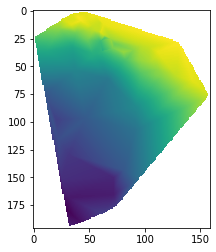

In [13]:
import matplotlib.pyplot as plt

plt.imshow(resuinter)
plt.show()